In [1]:
Nusers = 1000
Nmovies = 100

In [ ]:
import math
import numpy as np
import random
# S = np.random.randint(2, 6)   # Number of satellites (between 2 to 5)
# U = np.random.randint(5, 15)  # Number of UAVs (between 5 to 15)
# K = np.random.randint(2, 6)   # Number of CSPs (between 2 to 5)
# F = np.random.randint(10, 50) # Number of content files (10 to 50)
# N = np.random.randint(20, 100) # Number of GUs (20 to 100)
# # Maximum number of files UAV can store (F' << F)
# F_prime = np.random.randint(1, max(2, F // 2))  # At most 1/2 of total files
S = 2
U = 8
K = 2
N = Nusers
F = Nmovies
F_prime = F//3
M_u = 20
L = np.full(U, (F_prime)//5) # define transmissino load for each uav
# print(L)

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load datasets
movies = pd.read_csv(r'..\Data\movies.dat', sep="::",nrows=Nmovies, names=['movieId', 'title', 'genres'], engine='python', encoding='ISO-8859-1')
ratings = pd.read_csv(r'..\Data\ratings.dat', sep="::", names=['userId', 'movieId', 'rating', 'timestamp'], engine='python')
users = pd.read_csv(r'..\Data\users.dat', sep="::",nrows=Nusers, names=['userId', 'gender', 'age', 'occupation', 'zip-code'], engine='python')

# Merge datasets
merged_data = pd.merge(ratings, users, on='userId', how='inner')
merged_data = pd.merge(merged_data, movies, on='movieId', how='inner')


c:\Users\athya\anaconda3\envs\py310\lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy.sparse import csr_matrix, issparse


In [4]:
# Sorting by timestamp
merged_data = merged_data.sort_values(by='timestamp')

# Define number of timeslots
num_timeslots = 10

# Create timeslot labels
merged_data['timeslot'] = pd.qcut(merged_data['timestamp'], q=num_timeslots, labels=[int(f'{i+1}') for i in range(num_timeslots)])

# Display timeslot distribution
print(merged_data['timeslot'].value_counts())


merged_data


timeslot
9     515
1     514
2     514
3     514
4     514
5     514
7     514
8     514
6     513
10    513
Name: count, dtype: int64


userId  movieId  rating   timestamp gender  age  occupation zip-code  \
5138    1000        1       5   975041651      F   25           6    90027   
5117     999        6       2   975044156      M   25          15    62558   
5123     999       21       2   975044156      M   25          15    62558   
5132     999       70       2   975045753      M   25          15    62558   
5137     999       95       2   975045995      M   25          15    62558   
...      ...      ...     ...         ...    ...  ...         ...      ...   
3792     736        1       3  1045710680      M   18          12    07070   
3796     736       32       5  1045711057      M   18          12    07070   
3797     736       47       5  1045711096      M   18          12    07070   
3793     736        6       4  1045711853      M   18          12    07070   
4288     839       69       4  1045857035      M   25           0    98103   

                           title                               genres timeslot  
5138            Toy Story (1995)          Animation|Children's|Comedy        1  
5117                 Heat (1995)                Action|Crime|Thriller        1  
5123           Get Shorty (1995)                  Action|Comedy|Drama        1  
5132  From Dusk Till Dawn (1996)  Action|Comedy|Crime|Horror|Thriller        1  
5137         Broken Arrow (1996)                      Action|Thriller        1  
...                          ...                                  ...      ...  
3792            Toy Story (1995)          Animation|Children's|Comedy       10  
3796       Twelve Monkeys (1995)                         Drama|Sci-Fi       10  
3797        Seven (Se7en) (1995)                       Crime|Thriller       10  
3793                 Heat (1995)                Action|Crime|Thriller       10  
4288               Friday (1995)                               Comedy       10  

[5139 rows x 11 columns]

In [5]:
merged_data.drop("title",axis=1,inplace=True)

In [6]:
merged_data

userId  movieId  rating   timestamp gender  age  occupation zip-code  \
5138    1000        1       5   975041651      F   25           6    90027   
5117     999        6       2   975044156      M   25          15    62558   
5123     999       21       2   975044156      M   25          15    62558   
5132     999       70       2   975045753      M   25          15    62558   
5137     999       95       2   975045995      M   25          15    62558   
...      ...      ...     ...         ...    ...  ...         ...      ...   
3792     736        1       3  1045710680      M   18          12    07070   
3796     736       32       5  1045711057      M   18          12    07070   
3797     736       47       5  1045711096      M   18          12    07070   
3793     736        6       4  1045711853      M   18          12    07070   
4288     839       69       4  1045857035      M   25           0    98103   

                                   genres timeslot  
5138          Animation|Children's|Comedy        1  
5117                Action|Crime|Thriller        1  
5123                  Action|Comedy|Drama        1  
5132  Action|Comedy|Crime|Horror|Thriller        1  
5137                      Action|Thriller        1  
...                                   ...      ...  
3792          Animation|Children's|Comedy       10  
3796                         Drama|Sci-Fi       10  
3797                       Crime|Thriller       10  
3793                Action|Crime|Thriller       10  
4288                               Comedy       10  

[5139 rows x 10 columns]

First find all unique genres list

In [7]:
# Get unique genres from the dataset
unique_genres = set()

# Iterate through all genres and split them by '|'
for genre_list in merged_data['genres'].dropna():
    unique_genres.update(genre_list.split('|'))

# Convert set to a sorted list
unique_genres = sorted(unique_genres)

# Display unique genres
print(len(unique_genres)," : ",unique_genres)


16  :  ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War']


In [8]:
for genre in unique_genres:
    merged_data[genre] = merged_data['genres'].apply(lambda x: 1 if genre in x.split('|') else 0)


merged_data.drop(columns=['genres'], inplace=True)


In [9]:
merged_data

userId  movieId  rating   timestamp gender  age  occupation zip-code  \
5138    1000        1       5   975041651      F   25           6    90027   
5117     999        6       2   975044156      M   25          15    62558   
5123     999       21       2   975044156      M   25          15    62558   
5132     999       70       2   975045753      M   25          15    62558   
5137     999       95       2   975045995      M   25          15    62558   
...      ...      ...     ...         ...    ...  ...         ...      ...   
3792     736        1       3  1045710680      M   18          12    07070   
3796     736       32       5  1045711057      M   18          12    07070   
3797     736       47       5  1045711096      M   18          12    07070   
3793     736        6       4  1045711853      M   18          12    07070   
4288     839       69       4  1045857035      M   25           0    98103   

     timeslot  Action  ...  Documentary  Drama  Fantasy  Horror  Musical  \
5138        1       0  ...            0      0        0       0        0   
5117        1       1  ...            0      0        0       0        0   
5123        1       1  ...            0      1        0       0        0   
5132        1       1  ...            0      0        0       1        0   
5137        1       1  ...            0      0        0       0        0   
...       ...     ...  ...          ...    ...      ...     ...      ...   
3792       10       0  ...            0      0        0       0        0   
3796       10       0  ...            0      1        0       0        0   
3797       10       0  ...            0      0        0       0        0   
3793       10       1  ...            0      0        0       0        0   
4288       10       0  ...            0      0        0       0        0   

      Mystery  Romance  Sci-Fi  Thriller  War  
5138        0        0       0         0    0  
5117        0        0       0         1    0  
5123        0        0       0         0    0  
5132        0        0       0         1    0  
5137        0        0       0         1    0  
...       ...      ...     ...       ...  ...  
3792        0        0       0         0    0  
3796        0        0       1         0    0  
3797        0        0       0         1    0  
3793        0        0       0         1    0  
4288        0        0       0         0    0  

[5139 rows x 25 columns]

In [10]:
merged_data
merged_data['gender'] = merged_data['gender'].map({'M': 0,'F':1})

In [11]:
merged_data.describe()
zip_mapping = {zip_code: idx for idx, zip_code in enumerate(merged_data["zip-code"].unique())}

# Apply mapping
merged_data['zip-code'] =merged_data['zip-code'].map(zip_mapping)

In [12]:
df = merged_data[['userId', 'gender', 'age', 'occupation', 'zip-code',
       'movieId'] + unique_genres+ ['rating']]

In [13]:
dataset_test = users.merge(movies, how='cross')
for genre in unique_genres:
    dataset_test[genre] = dataset_test['genres'].apply(lambda x: 1 if genre in x.split('|') else 0)


dataset_test.drop(columns=['genres'], inplace=True)
dataset_test.drop(columns=['title'], inplace=True)
dataset_test['gender'] = dataset_test['gender'].map({'M': 0,'F':1})

zip_mapping = {zip_code: idx for idx, zip_code in enumerate(dataset_test["zip-code"].unique())}

# Apply mapping
dataset_test['zip-code'] = dataset_test['zip-code'].map(zip_mapping)
print(dataset_test)
dataset_test = dataset_test.merge(df[['userId', 'movieId', 'rating']], 
                                  on=['userId', 'movieId'], 
                                  how='left')
dataset_test.fillna(0,inplace=True)


# Unique users and movies
unique_users = dataset_test["userId"].unique()      # = Nusers
unique_movies = dataset_test["movieId"].unique()        # = Nmovies

# Create mapping from original IDs to indices (starting from 1)
user_to_index = {user: idx + 1 for idx, user in enumerate(unique_users)}
movie_to_index = {movie: idx + 1 for idx, movie in enumerate(unique_movies)}

# Replace values in the DataFrame
dataset_test["userId"] = dataset_test["userId"].map(user_to_index)
dataset_test["movieId"] = dataset_test["movieId"].map(movie_to_index)



dataset_test.to_csv('dataset_test.csv')

       userId  gender  age  occupation  zip-code  movieId  Action  Adventure  \
0           1       1    1          10         0        1       0          0   
1           1       1    1          10         0        2       0          1   
2           1       1    1          10         0        3       0          0   
3           1       1    1          10         0        4       0          0   
4           1       1    1          10         0        5       0          0   
...       ...     ...  ...         ...       ...      ...     ...        ...   
99995    1000       1   25           6       269       97       0          0   
99996    1000       1   25           6       269       98       1          0   
99997    1000       1   25           6       269       99       0          0   
99998    1000       1   25           6       269      100       0          0   
99999    1000       1   25           6       269      101       0          0   

       Animation  Children's  ...  Docu

In [14]:
dataset_test = pd.read_csv('dataset_test.csv')


In [15]:
dataset_test

Unnamed: 0  userId  gender  age  occupation  zip-code  movieId  Action  \
0               0       1       1    1          10         0        1       0   
1               1       1       1    1          10         0        2       0   
2               2       1       1    1          10         0        3       0   
3               3       1       1    1          10         0        4       0   
4               4       1       1    1          10         0        5       0   
...           ...     ...     ...  ...         ...       ...      ...     ...   
99995       99995    1000       1   25           6       269       96       0   
99996       99996    1000       1   25           6       269       97       1   
99997       99997    1000       1   25           6       269       98       0   
99998       99998    1000       1   25           6       269       99       0   
99999       99999    1000       1   25           6       269      100       0   

       Adventure  Animation  ...  Drama  Fantasy  Horror  Musical  Mystery  \
0              0          1  ...      0        0       0        0        0   
1              1          0  ...      0        1       0        0        0   
2              0          0  ...      0        0       0        0        0   
3              0          0  ...      1        0       0        0        0   
4              0          0  ...      0        0       0        0        0   
...          ...        ...  ...    ...      ...     ...      ...      ...   
99995          0          0  ...      1        0       0        0        0   
99996          0          0  ...      0        0       0        0        0   
99997          0          0  ...      0        0       0        0        0   
99998          0          0  ...      1        0       0        0        0   
99999          0          0  ...      0        0       0        0        0   

       Romance  Sci-Fi  Thriller  War  rating  
0            0       0         0    0     5.0  
1            0       0         0    0     0.0  
2            1       0         0    0     0.0  
3            0       0         0    0     0.0  
4            0       0         0    0     0.0  
...        ...     ...       ...  ...     ...  
99995        0       0         0    0     0.0  
99996        0       0         1    0     0.0  
99997        0       0         0    0     0.0  
99998        0       0         1    0     0.0  
99999        0       0         0    0     0.0  

[100000 rows x 24 columns]

In [16]:
dataset_test

Unnamed: 0  userId  gender  age  occupation  zip-code  movieId  Action  \
0               0       1       1    1          10         0        1       0   
1               1       1       1    1          10         0        2       0   
2               2       1       1    1          10         0        3       0   
3               3       1       1    1          10         0        4       0   
4               4       1       1    1          10         0        5       0   
...           ...     ...     ...  ...         ...       ...      ...     ...   
99995       99995    1000       1   25           6       269       96       0   
99996       99996    1000       1   25           6       269       97       1   
99997       99997    1000       1   25           6       269       98       0   
99998       99998    1000       1   25           6       269       99       0   
99999       99999    1000       1   25           6       269      100       0   

       Adventure  Animation  ...  Drama  Fantasy  Horror  Musical  Mystery  \
0              0          1  ...      0        0       0        0        0   
1              1          0  ...      0        1       0        0        0   
2              0          0  ...      0        0       0        0        0   
3              0          0  ...      1        0       0        0        0   
4              0          0  ...      0        0       0        0        0   
...          ...        ...  ...    ...      ...     ...      ...      ...   
99995          0          0  ...      1        0       0        0        0   
99996          0          0  ...      0        0       0        0        0   
99997          0          0  ...      0        0       0        0        0   
99998          0          0  ...      1        0       0        0        0   
99999          0          0  ...      0        0       0        0        0   

       Romance  Sci-Fi  Thriller  War  rating  
0            0       0         0    0     5.0  
1            0       0         0    0     0.0  
2            1       0         0    0     0.0  
3            0       0         0    0     0.0  
4            0       0         0    0     0.0  
...        ...     ...       ...  ...     ...  
99995        0       0         0    0     0.0  
99996        0       0         1    0     0.0  
99997        0       0         0    0     0.0  
99998        0       0         1    0     0.0  
99999        0       0         0    0     0.0  

[100000 rows x 24 columns]

In [17]:
df

userId  gender  age  occupation  zip-code  movieId  Action  Adventure  \
5138    1000       1   25           6         0        1       0          0   
5117     999       0   25          15         1        6       1          0   
5123     999       0   25          15         1       21       1          0   
5132     999       0   25          15         1       70       1          0   
5137     999       0   25          15         1       95       1          0   
...      ...     ...  ...         ...       ...      ...     ...        ...   
3792     736       0   18          12       183        1       0          0   
3796     736       0   18          12       183       32       0          0   
3797     736       0   18          12       183       47       0          0   
3793     736       0   18          12       183        6       1          0   
4288     839       0   25           0       116       69       0          0   

      Animation  Children's  ...  Drama  Fantasy  Horror  Musical  Mystery  \
5138          1           1  ...      0        0       0        0        0   
5117          0           0  ...      0        0       0        0        0   
5123          0           0  ...      1        0       0        0        0   
5132          0           0  ...      0        0       1        0        0   
5137          0           0  ...      0        0       0        0        0   
...         ...         ...  ...    ...      ...     ...      ...      ...   
3792          1           1  ...      0        0       0        0        0   
3796          0           0  ...      1        0       0        0        0   
3797          0           0  ...      0        0       0        0        0   
3793          0           0  ...      0        0       0        0        0   
4288          0           0  ...      0        0       0        0        0   

      Romance  Sci-Fi  Thriller  War  rating  
5138        0       0         0    0       5  
5117        0       0         1    0       2  
5123        0       0         0    0       2  
5132        0       0         1    0       2  
5137        0       0         1    0       2  
...       ...     ...       ...  ...     ...  
3792        0       0         0    0       3  
3796        0       1         0    0       5  
3797        0       0         1    0       5  
3793        0       0         1    0       4  
4288        0       0         0    0       4  

[5139 rows x 23 columns]

In [18]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
X = df[['userId', 'gender', 'age', 'occupation', 'zip-code',
       'movieId',] + unique_genres] 
y = df['rating']



X_train, y_train = X, y


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
# Train data
X_train_raw = X
y_train = y

# Normalize
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
# X_test_scaled = scaler.transform(X_test_raw)

# Reshape for LSTM
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
# X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [20]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

# Define the model
model = Sequential()

# Layer 1: First LSTM layer with 24 units and return_sequences=True
model.add(LSTM(24, return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))

# Layer 2: Second LSTM layer with 24 units
model.add(LSTM(24, return_sequences=True))

# Layer 3: Third LSTM layer with 12 units
model.add(LSTM(12))

# Output layer: Fully connected (Dense) layer with linear activation
model.add(Dense(1, activation='linear'))

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_absolute_error')
model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
161/161 [==============================] - 9s 7ms/step - loss: 2.9586
Epoch 2/20
161/161 [==============================] - 1s 7ms/step - loss: 0.9119
Epoch 3/20
161/161 [==============================] - 1s 6ms/step - loss: 0.8724
Epoch 4/20
161/161 [==============================] - 1s 7ms/step - loss: 0.8614
Epoch 5/20
161/161 [==============================] - 1s 6ms/step - loss: 0.8538
Epoch 6/20
161/161 [==============================] - 1s 6ms/step - loss: 0.8484
Epoch 7/20
161/161 [==============================] - 1s 6ms/step - loss: 0.8431
Epoch 8/20
161/161 [==============================] - 1s 7ms/step - loss: 0.8393
Epoch 9/20
161/161 [==============================] - 1s 8ms/step - loss: 0.8359
Epoch 10/20
161/161 [==============================] - 1s 8ms/step - loss: 0.8341
Epoch 11/20
161/161 [==============================] - 1s 7ms/step - loss: 0.8309
Epoch 12/20
161/161 [==============================] - 1s 7ms/step - loss: 0.8287
Epoch 13/20
161/161 [====

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 24)             4512      
                                                                 
 lstm_1 (LSTM)               (None, 1, 24)             4704      
                                                                 
 lstm_2 (LSTM)               (None, 12)                1776      
                                                                 
 dense (Dense)               (None, 1)                 13        
                                                                 
Total params: 11,005
Trainable params: 11,005
Non-trainable params: 0
_________________________________________________________________


In [22]:
X_test = dataset_test[['userId', 'gender', 'age', 'occupation', 'zip-code',
       'movieId']+ unique_genres]
y_test = dataset_test['rating']

In [23]:
X_test_scaled = scaler.transform(X_test)  # Use .transform, not .fit_transform
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
preds = model.predict(X_test_lstm)


3125/3125 [==============================] - 8s 2ms/step


In [24]:
actual_q_i_f =  dataset_test.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)
actual_q_i_f


predicted_q_i_f = np.zeros((Nusers, Nmovies))


unique_users = dataset_test["userId"].unique()      # = Nusers
unique_movies = dataset_test["movieId"].unique()        # = Nmovies


test_user_ids = dataset_test["userId"].values
test_movie_ids = dataset_test["movieId"].values
print(len(pd.Series(test_user_ids).unique()))

user_to_index = {user: idx for idx, user in enumerate(unique_users)}
movie_to_index = {movie: idx for idx, movie in enumerate(unique_movies)}

# Fill the matrix
for i in range(len(preds)):
    user_idx = user_to_index[test_user_ids[i]]
    movie_idx = movie_to_index[test_movie_ids[i]]
    # print(user_idx,movie_idx)
    predicted_q_i_f[user_idx][movie_idx] = preds[i]
    # print(predicted_q_i_f[user_idx][movie_idx])

print("Matrix filled with predicted ratings.")
# Resulting 2D array: predicted_q_i_f
print(predicted_q_i_f.shape)


# if np.all(predicted_q_i_f == 0):
#     print("The matrix contains only zeros.")
# else:
#     print("The matrix has non-zero values.")

non_zero_count = np.count_nonzero(predicted_q_i_f)
total_elements = predicted_q_i_f.size

print(f"Non-zero elements: {non_zero_count}")
print(f"Total elements: {total_elements}")
print(f"Percentage of non-zero values: {(non_zero_count / total_elements) * 100:.4f}%")



1000
Matrix filled with predicted ratings.
(1000, 100)
Non-zero elements: 100000
Total elements: 100000
Percentage of non-zero values: 100.0000%


In [25]:
actual_q_i_f

movieId  1    2    3    4    5    6    7    8    9    10   ...  91   92   93   \
userId                                                     ...                  
1        5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
5        0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
996      4.0  0.0  0.0  0.0  0.0  4.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
997      4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
998      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
999      0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  4.0  0.0  ...  0.0  0.0  0.0   
1000     5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

movieId  94   95   96   97   98   99   100  
userId                                      
1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2        2.0  0.0  0.0  0.0  0.0  0.0  0.0  
3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5        0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...      ...  ...  ...  ...  ...  ...  ...  
996      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
997      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
998      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
999      2.0  0.0  0.0  0.0  0.0  0.0  0.0  
1000     0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[1000 rows x 100 columns]

In [26]:
predicted_q_i_f = pd.DataFrame(predicted_q_i_f)
predicted_q_i_f.index = range(1, predicted_q_i_f.shape[0] + 1)
predicted_q_i_f.columns = range(1, predicted_q_i_f.shape[1] + 1)
predicted_q_i_f.index.name = "userId"  
predicted_q_i_f.columns.name = "movieId"
predicted_q_i_f

movieId       1         2         3         4         5         6         7    \
userId                                                                          
1        3.735456  2.252336  2.549205  3.594939  2.215548  3.711799  2.561995   
2        3.842906  2.511648  2.703537  3.715240  2.400438  3.822917  2.717669   
3        3.765043  2.236077  2.402709  3.628734  2.089200  3.748903  2.418948   
4        3.826861  2.405498  2.577204  3.695390  2.284764  3.810420  2.593239   
5        3.760014  2.251731  2.425834  3.625000  2.103676  3.742543  2.441258   
...           ...       ...       ...       ...       ...       ...       ...   
996      4.121375  3.534120  3.668359  4.065625  3.533428  4.097952  3.673633   
997      4.092916  3.421276  3.571942  4.035777  3.424704  4.068421  3.577358   
998      4.076103  3.352576  3.532878  4.009469  3.360961  4.048022  3.539043   
999      4.123463  3.539916  3.671005  4.068232  3.539272  4.100582  3.675998   
1000     4.042377  3.248017  3.511966  3.969800  3.332167  4.012859  3.516929   

movieId       8         9         10   ...       91        92        93   \
userId                                 ...                                 
1        2.865511  1.528919  2.768878  ...  3.711023  2.753865  3.558086   
2        3.126823  1.772853  3.016986  ...  3.856673  2.942694  3.725767   
3        2.914559  1.437064  2.806039  ...  3.790651  2.676978  3.633399   
4        3.055211  1.613558  2.951570  ...  3.847469  2.847981  3.708314   
5        2.921153  1.470707  2.808940  ...  3.784183  2.687691  3.627087   
...           ...       ...       ...  ...       ...       ...       ...   
996      3.825225  3.070607  3.733986  ...  4.109773  3.745896  4.059201   
997      3.752606  2.891356  3.654706  ...  4.082805  3.656976  4.024727   
998      3.704633  2.842271  3.602191  ...  4.062088  3.623238  3.999721   
999      3.829219  3.077434  3.739125  ...  4.112370  3.749012  4.062303   
1000     3.610748  2.797453  3.524689  ...  4.007473  3.580334  3.942908   

movieId       94        95        96        97        98        99        100  
userId                                                                         
1        2.249427  2.455914  3.558818  2.251014  2.916084  3.712064  2.464830  
2        2.557835  2.678084  3.726599  2.560014  3.216017  3.858345  2.688937  
3        2.284854  2.402437  3.634503  2.287421  3.005229  3.792541  2.414667  
4        2.472251  2.594163  3.709610  2.474915  3.145652  3.849293  2.606122  
5        2.289322  2.404772  3.628318  2.291755  3.010759  3.785962  2.416942  
...           ...       ...       ...       ...       ...       ...       ...  
996      3.473941  3.635430  4.059501  3.474621  3.848924  4.109986  3.638981  
997      3.354362  3.537049  4.024801  3.355131  3.777372  4.082781  3.540720  
998      3.302822  3.479275  3.999963  3.303316  3.743834  4.062338  3.483220  
999      3.481335  3.641786  4.062384  3.482179  3.851834  4.112682  3.645042  
1000     3.202921  3.422276  3.943099  3.202662  3.637845  4.007390  3.424551  

[1000 rows x 100 columns]

In [27]:
print("Actual\t|Predicted\t|Difference\t|")
for i in range(len(y_test)):  # Use len(y_test) instead of a fixed number
    print(y_test.iloc[i], "\t|", preds[i], "\t|", y_test.iloc[i] - preds[i], "\t|")


Actual	|Predicted	|Difference	|
5.0 	| [3.735456] 	| [1.264544] 	|
0.0 	| [2.2523363] 	| [-2.2523363] 	|
0.0 	| [2.5492046] 	| [-2.5492046] 	|
0.0 	| [3.5949385] 	| [-3.5949385] 	|
0.0 	| [2.2155483] 	| [-2.2155483] 	|
0.0 	| [3.7117994] 	| [-3.7117994] 	|
0.0 	| [2.5619946] 	| [-2.5619946] 	|
0.0 	| [2.8655112] 	| [-2.8655112] 	|
0.0 	| [1.528919] 	| [-1.528919] 	|
0.0 	| [2.768878] 	| [-2.768878] 	|
0.0 	| [3.7432964] 	| [-3.7432964] 	|
0.0 	| [1.1672559] 	| [-1.1672559] 	|
0.0 	| [3.6136947] 	| [-3.6136947] 	|
0.0 	| [3.5162253] 	| [-3.5162253] 	|
0.0 	| [2.4473379] 	| [-2.4473379] 	|
0.0 	| [3.684093] 	| [-3.684093] 	|
0.0 	| [3.6712732] 	| [-3.6712732] 	|
0.0 	| [2.5320318] 	| [-2.5320318] 	|
0.0 	| [2.263677] 	| [-2.263677] 	|
0.0 	| [1.5543424] 	| [-1.5543424] 	|
0.0 	| [3.449468] 	| [-3.449468] 	|
0.0 	| [4.1415253] 	| [-4.1415253] 	|
0.0 	| [2.542197] 	| [-2.542197] 	|
0.0 	| [3.7170937] 	| [-3.7170937] 	|
0.0 	| [3.6756215] 	| [-3.6756215] 	|
0.0 	| [3.5258875] 	| [-3.5258875

In [28]:
print("Actual\t|Predicted\t|Difference\t|")
for i in range(len(y_test)):  # Use len(y_test) instead of a fixed number
    print(y_test.iloc[i], "\t|", preds[i].round(), "\t|", y_test.iloc[i] - preds[i].round(), "\t|")


Actual	|Predicted	|Difference	|
5.0 	| [4.] 	| [1.] 	|
0.0 	| [2.] 	| [-2.] 	|
0.0 	| [3.] 	| [-3.] 	|
0.0 	| [4.] 	| [-4.] 	|
0.0 	| [2.] 	| [-2.] 	|
0.0 	| [4.] 	| [-4.] 	|
0.0 	| [3.] 	| [-3.] 	|
0.0 	| [3.] 	| [-3.] 	|
0.0 	| [2.] 	| [-2.] 	|
0.0 	| [3.] 	| [-3.] 	|
0.0 	| [4.] 	| [-4.] 	|
0.0 	| [1.] 	| [-1.] 	|
0.0 	| [4.] 	| [-4.] 	|
0.0 	| [4.] 	| [-4.] 	|
0.0 	| [2.] 	| [-2.] 	|
0.0 	| [4.] 	| [-4.] 	|
0.0 	| [4.] 	| [-4.] 	|
0.0 	| [3.] 	| [-3.] 	|
0.0 	| [2.] 	| [-2.] 	|
0.0 	| [2.] 	| [-2.] 	|
0.0 	| [3.] 	| [-3.] 	|
0.0 	| [4.] 	| [-4.] 	|
0.0 	| [3.] 	| [-3.] 	|
0.0 	| [4.] 	| [-4.] 	|
0.0 	| [4.] 	| [-4.] 	|
0.0 	| [4.] 	| [-4.] 	|
0.0 	| [4.] 	| [-4.] 	|
0.0 	| [2.] 	| [-2.] 	|
0.0 	| [3.] 	| [-3.] 	|
0.0 	| [4.] 	| [-4.] 	|
0.0 	| [4.] 	| [-4.] 	|
0.0 	| [4.] 	| [-4.] 	|
0.0 	| [3.] 	| [-3.] 	|
0.0 	| [4.] 	| [-4.] 	|
0.0 	| [4.] 	| [-4.] 	|
0.0 	| [4.] 	| [-4.] 	|
0.0 	| [3.] 	| [-3.] 	|
0.0 	| [2.] 	| [-2.] 	|
0.0 	| [3.] 	| [-3.] 	|
0.0 	| [4.] 	| [-4.] 	|
0.0 	| [4

In [29]:
print(mean_absolute_error(y_test,preds))
import numpy as np
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE:", rmse)


3.454788458621502
RMSE: 3.5461304668477056


Declaring Function to compute states and action

In [31]:
import numpy as np

# Step 1: Clustering UAVs to Satellites (1-Based Indexing)
num_clusters = S
uav_indices = np.arange(1, U + 1)  # Start from 1 instead of 0
np.random.shuffle(uav_indices)  # Shuffle UAVs for random assignment
UAVs_per_cluster = np.array_split(uav_indices, num_clusters)

print("Clusters of UAVs:", [list(cluster) for cluster in UAVs_per_cluster])

# Step 2: Assign Ground Users to UAVs Randomly While Satisfying Capacity Constraints
GU_list = np.arange(1, N + 1)  # List of Ground Users (1-based indexing)
np.random.shuffle(GU_list)  # Shuffle GUs for random assignment

# Initialize User-UAV Association Matrix (U x N) (1-Based Indexing)
X_ui = np.zeros((U, N), dtype=int)

GU_assignment = {}  # Dictionary to store cluster-wise assignment
GU_counter = 0  # Start GU numbering from 1

# Assign users to UAVs randomly while ensuring max capacity constraint
for cluster_id, uav_list in enumerate(UAVs_per_cluster, start=1):  # Start cluster from 1
    GU_assignment[cluster_id] = {}
    for uav in uav_list:
        if GU_counter >= N:  # If all users are assigned, stop
            break
        
        # Determine how many users to assign (between 1 and M_u)
        num_GUs = min(np.random.randint(1, M_u + 1), N - GU_counter)
        
        # Assign GUs to UAV (1-Based Indexing)
        assigned_GUs = list(GU_list[GU_counter:GU_counter + num_GUs])
        GU_assignment[cluster_id][uav] = assigned_GUs

        # Update User-UAV a
        # 
        # ssociation matrix (1-Based Indexing)
        for gu in assigned_GUs:
            X_ui[uav - 1, gu - 1] = 1  # Adjust for 0-based indexing in NumPy
        
        GU_counter += num_GUs

# Ensure all users are assigned (handling unassigned GUs)
all_assigned_GUs = sum(len(gus) for cluster in GU_assignment.values() for gus in cluster.values())
unassigned_GUs = N - all_assigned_GUs

if unassigned_GUs > 0:
    all_uavs = [uav for cluster in GU_assignment.values() for uav in cluster.keys()]
    np.random.shuffle(all_uavs)  # Shuffle UAVs for fair distribution
    for i in range(unassigned_GUs):
        selected_uav = all_uavs[i % len(all_uavs)]
        for cluster_id, uavs in GU_assignment.items():
            if selected_uav in uavs and len(uavs[selected_uav]) < M_u:
                GU_assignment[cluster_id][selected_uav].append(GU_list[GU_counter])
                X_ui[selected_uav - 1, GU_list[GU_counter] - 1] = 1  # Adjust for NumPy indexing
                GU_counter += 1
                break

# Print Results
print(f"Satellites (S): {S}, UAVs (U): {U}, Ground Users (N): {N}, Clusters: {num_clusters}, Max Users per UAV: {M_u}")

print("\nCluster Assignments:")
for cluster, uavs in GU_assignment.items():
    print(f"Cluster {cluster}:")
    for uav, gu_list in uavs.items():
        print(f"  UAV {uav}: {len(gu_list)} GUs -> {gu_list}")

print("\nUser-UAV Association Matrix (X_ui):")
print(X_ui)   # U x N


Clusters of UAVs: [[1, 7, 3, 6], [2, 8, 5, 4]]
Satellites (S): 2, UAVs (U): 8, Ground Users (N): 1000, Clusters: 2, Max Users per UAV: 20

Cluster Assignments:
Cluster 1:
  UAV 1: 20 GUs -> [799, 513, 929, 774, 86, 808, 714, 555, 820, 757, 35, 769, 896, 509, 635, 954, 242, 93, 208, 712]
  UAV 7: 20 GUs -> [613, 655, 675, 373, 955, 569, 596, 822, 574, 658, 588, 851, 768, 40, 324, 136, 64, 614, 738, 159]
  UAV 3: 20 GUs -> [227, 221, 171, 800, 576, 809, 297, 536, 557, 913, 829, 684, 970, 66, 101, 752, 238, 367, 733, 729]
  UAV 6: 20 GUs -> [493, 215, 934, 603, 352, 566, 973, 834, 640, 615, 447, 469, 681, 274, 474, 46, 123, 1000, 210, 558]
Cluster 2:
  UAV 2: 20 GUs -> [368, 451, 998, 176, 542, 578, 193, 545, 226, 695, 103, 280, 775, 70, 437, 756, 222, 442, 591, 734]
  UAV 8: 20 GUs -> [389, 882, 708, 630, 723, 331, 408, 661, 163, 565, 701, 172, 498, 850, 767, 871, 505, 117, 687, 966]
  UAV 5: 20 GUs -> [667, 967, 621, 847, 50, 846, 599, 262, 532, 24, 720, 47, 345, 377, 676, 43, 694, 264,

In [32]:
X_ui.shape   # ( U, N)

(8, 1000)

In [33]:

def content_popularity_prediction(N, F, u, X_ui, predicted_q_i_f):
    """
    Calculate total content popularity Q^f_u(t) for each content f for UAV 'u'.

    Parameters:
    - N (int): Total number of GUs
    - F (int): Number of content files
    - u (int): UAV ID for which popularity is calculated
    - X_ui (np.array): User-UAV Association Matrix (U x N)
    - predicted_q_i_f (np.array): Popularity matrix (N x F), each element q_i^f(t)

    Returns:
    - Q_f_u (np.array): Total popularity array for each content f for UAV 'u'
    """
    Q_f_u = np.zeros(F)  # Initialize total requests for UAV 'u'
    for f in range(F):
        temp = 0
        for i in range(N):  # Iterate over all users
            if X_ui[u-1][i] == 1:  # If user 'i' is associated with UAV 'u'
                temp += predicted_q_i_f[f+1][i+1]  # Add the user's requests
        Q_f_u[f] = temp

    return Q_f_u


# Compute content popularity for a specific UAV (e.g., UAV 1)
predicted_Q_f_u = content_popularity_prediction(N, F, 1, X_ui, predicted_q_i_f)

# Print Results
print(f"\nTotal Requests for UAV {1} (Q^f_u):")
print(predicted_Q_f_u)



Total Requests for UAV 1 (Q^f_u):
[79.8573494  60.70404673 64.35381484 78.16887951 60.26792574 79.39361691
 64.53441429 69.67275786 48.19837773 67.72683001 79.72889519 40.60333931
 78.61218905 77.47328925 62.53973746 79.40738821 78.9976902  65.26072073
 61.00237322 48.69749904 75.99152446 84.73923731 65.39927983 79.73035455
 79.05581403 77.594033   77.6040225  62.42503142 73.80080175 77.63215804
 77.6408     79.77329826 69.93586493 79.85250115 79.12126398 77.68348265
 70.00148869 61.88561273 65.80389428 77.71647239 79.89312053 83.04839087
 77.73972487 60.49396348 78.65623498 79.18290591 81.41529083 78.02787399
 79.19913077 81.41686559 77.52140093 62.45739007 77.81062341 66.79340792
 77.82430434 61.19866705 77.83707023 79.24031901 72.18865132 61.20810819
 79.64769101 77.86722589 62.86269426 66.58276963 62.93341804 72.235991
 77.89456844 66.69096971 63.06900525 75.174999   50.46223211 78.88582897
 78.27972269 79.29936552 78.90733814 72.32733393 70.44608951 77.94776607
 79.70612502 77.95

In [34]:
predicted_Q_f_all_uav=[]
for u in range(0,U):
    predicted_Q_f_all_uav.append(content_popularity_prediction(N,F,u+1,X_ui,predicted_q_i_f))
print("array storing total requests count for all UAV set\n",predicted_Q_f_all_uav)



array storing total requests count for all UAV set
 [array([79.8573494 , 60.70404673, 64.35381484, 78.16887951, 60.26792574,
       79.39361691, 64.53441429, 69.67275786, 48.19837773, 67.72683001,
       79.72889519, 40.60333931, 78.61218905, 77.47328925, 62.53973746,
       79.40738821, 78.9976902 , 65.26072073, 61.00237322, 48.69749904,
       75.99152446, 84.73923731, 65.39927983, 79.73035455, 79.05581403,
       77.594033  , 77.6040225 , 62.42503142, 73.80080175, 77.63215804,
       77.6408    , 79.77329826, 69.93586493, 79.85250115, 79.12126398,
       77.68348265, 70.00148869, 61.88561273, 65.80389428, 77.71647239,
       79.89312053, 83.04839087, 77.73972487, 60.49396348, 78.65623498,
       79.18290591, 81.41529083, 78.02787399, 79.19913077, 81.41686559,
       77.52140093, 62.45739007, 77.81062341, 66.79340792, 77.82430434,
       61.19866705, 77.83707023, 79.24031901, 72.18865132, 61.20810819,
       79.64769101, 77.86722589, 62.86269426, 66.58276963, 62.93341804,
       72.2

In [35]:
def rank_function(predicted_Q_f, predicted_Q_list):
    """
    Calculate the rank of a specific content f based on its estimated popularity Q_f.

    Args:
        predicted_Q_f (float): Popularity of a specific content f for a UAV.
        predicted_Q_list (list of float): Popularities of all contents for the same UAV.

    Returns:
        int: Rank of the content (lower rank means higher popularity).
    """
    return sum(predicted_Q_f <= predicted_Q_f_prime for predicted_Q_f_prime in predicted_Q_list)


# Dictionary to store rankings for all uav
rank_all_uav = {}

# Compute ranks for each UAV
for uav_idx , popularity_uav_list in enumerate(predicted_Q_f_all_uav):  
    temp_dict = {}
    for f_idx, popularity_val in enumerate(popularity_uav_list):
        rank = rank_function(popularity_val,popularity_uav_list)
        temp_dict[f_idx] = rank
    rank_all_uav[uav_idx] = temp_dict
    

# Print Rankings
print("\nRanks of each content for all UAVs one by one:")
for uav, content_ranks_dict in rank_all_uav.items():
    print(f"\nUAV {uav}:")
    for content, rank in content_ranks_dict.items():
        print(f"  Content {content}, Pop'Value {predicted_Q_f_all_uav[uav][content]} : Rank {rank}")


Ranks of each content for all UAVs one by one:

UAV 0:
  Content 0, Pop'Value 79.85734939575195 : Rank 8
  Content 1, Pop'Value 60.70404672622681 : Rank 91
  Content 2, Pop'Value 64.35381484031677 : Rank 77
  Content 3, Pop'Value 78.16887950897217 : Rank 33
  Content 4, Pop'Value 60.26792573928833 : Rank 96
  Content 5, Pop'Value 79.39361691474915 : Rank 18
  Content 6, Pop'Value 64.53441429138184 : Rank 76
  Content 7, Pop'Value 69.67275786399841 : Rank 66
  Content 8, Pop'Value 48.19837772846222 : Rank 99
  Content 9, Pop'Value 67.72683000564575 : Rank 67
  Content 10, Pop'Value 79.72889518737793 : Rank 14
  Content 11, Pop'Value 40.603339314460754 : Rank 100
  Content 12, Pop'Value 78.61218905448914 : Rank 31
  Content 13, Pop'Value 77.47328925132751 : Rank 55
  Content 14, Pop'Value 62.53973746299744 : Rank 84
  Content 15, Pop'Value 79.40738821029663 : Rank 17
  Content 16, Pop'Value 78.99769020080566 : Rank 26
  Content 17, Pop'Value 65.26072072982788 : Rank 75
  Content 18, Pop

In [36]:
def tilde_cache_placement_from_rank(F, F_prime,rank_all_uav):
    """
    Generate ideal cache placement vector Γ̃_u(t)  using content rank information with predicted popularity and ignoring transmission constraint

    Parameters:
    - F (int): Total number of content files.
    - F_prime (int): Cache storage limit (maximum number of files that can be cached).
    - predicted_rank_dict (dict): Dictionary where keys are content indices and values are ranks (integers) based on predicted content popularity.

    Returns:
    - Gamma_u (np.array): Binary cache placement vector (0 or 1).
    """
    # Initialize cache vector with zeros
    Gamma = np.zeros((U,F), dtype=int)
    # Iterate through rank dictionary and cache content with rank <= F'
    for uav, per_uav_rank_list in rank_all_uav.items():
        for f, rank in per_uav_rank_list.items():
            if rank <= F_prime:  
                Gamma[uav][f] = 1  # Cache this content

    return Gamma

# Compute cache placement vector
Gamma_tilde = tilde_cache_placement_from_rank(F, F_prime, rank_all_uav)

print("tilde Cache placement vector Γ(t):", Gamma_tilde)



tilde Cache placement vector Γ(t): [[1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0
  0 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1
  1 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0]
 [1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0
  0 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1
  1 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0
  0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1
  1 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0
  0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1
  1 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0]
 [1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0
  0 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0

In [37]:
def generate_random_cache_placement(U, F, F_prime):
    """
    Generate a random cache placement matrix for time slot (t-1).

    Parameters:
    - U (int): Number of UAVs.
    - F (int): Total number of content files.
    - F_prime (int): Cache storage limit per UAV.

    Returns:
    - Gamma_prev (np.array): Random binary cache placement matrix (U x F).
    """
    Gamma_prev = np.zeros((U, F), dtype=int)

    for uav in range(U):
        cached_files = np.random.choice(F, F_prime, replace=False)  # Select F' unique files
        Gamma_prev[uav, cached_files] = 1  # Mark selected files as cached

    return Gamma_prev

Gamma_t_minus_1 = generate_random_cache_placement(U, F, F_prime)
print("Random cache placement at time slot (t-1):\n", Gamma_t_minus_1)


Random cache placement at time slot (t-1):
 [[0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0
  1 1 1 1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
  0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0]
 [0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 0 0 1 0
  0 1 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0
  1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 1 0 0]
 [1 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0
  0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0
  1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0]
 [0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 1 0
  0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0
  0 0 1 1 0 0 1 0 0 1 0 1 1 0 0 0 1 1 0 0 0 0 1 0 1 1 1 0]
 [0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1
  0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 

Define Cache load $ \Delta{\Gamma_u(t)} = | \tilde{\Gamma}_u(t)  - \Gamma_u(t-1) |$

In [38]:
def cache_update_load(Gamma_tilde, Gamma_prev):
    """
    Calculate the cache update load ΔΓ_u(t) for each UAV separately.

    Parameters:
    - Gamma_tilde (np.array): Ideal cache placement matrix Γ̃(t) (U x F).
    - Gamma_prev (np.array): Previous cache placement matrix Γ(t-1) (U x F).

    Returns:
    - Delta_Gamma (np.array): Array of size (U,) containing updates needed for each UAV.
    """

    # Compute element-wise absolute difference and sum per UAV (row-wise)
    Delta_Gamma = np.sum(np.abs(Gamma_tilde - Gamma_prev), axis=1)

    return Delta_Gamma  # Shape: (U,)

# Compute cache update load per UAV
Delta_Gamma = cache_update_load(Gamma_tilde, Gamma_t_minus_1)

# Print results
print("Cache update load ΔΓ_u(t) for each UAV:", Delta_Gamma)


Cache update load ΔΓ_u(t) for each UAV: [44 42 42 46 46 40 48 40]


In [39]:
def update_cache_vector( Gamma_t_minus_1, Delta_Gamma, L, F_prime):
    """
    Updates the cache vector for all UAVs based on popularity, previous cache, and transmission capacity.

    Args:
        Gamma_t_minus_1 (np.array): Previous cache matrix (U x F).
        Delta_Gamma (np.array): Cache update load vector (U,).
        L (np.array): Transmission capacity vector (U,).
        F_prime (int): Cache storage limit.

    Returns:
        np.array: Updated cache matrix (U x F).
    """
    U, F = Gamma_t_minus_1.shape  # Get number of UAVs and total files
    Gamma_t = np.zeros((U, F), dtype=int)  # Initialize updated cache matrix

    for u in range(U):  # Iterate over each UAV
        if L[u] >= Delta_Gamma[u]:  
            Gamma_t[u] = Gamma_tilde[u]  # UAV can fully update cache
        else:
            # Step 1: Sort content by rank for the current UAV
            sorted_contents = sorted(rank_all_uav[u].keys(), key=lambda f: rank_all_uav[u][f])
            print(f"UAV {u+1}: Content indices with decreasing ranking: ", sorted_contents)

            # Step 2: Retain (F' - L[u]) files from previous cache based on popularity
            cached_indices = np.where(Gamma_t_minus_1[u] == 1)[0]
            print(f"UAV {u+1}: Previous cached state: ", cached_indices)

            retained_files = sorted(cached_indices, key=lambda f: rank_all_uav[u].get(f, float('inf')))[:F_prime - L[u]]
            print(f"UAV {u+1}: Files Retained: ", retained_files)

            # Step 3: Retrieve at most L[u] new files based on predicted ranks
            non_cached_indices = np.where(Gamma_t_minus_1[u] == 0)[0]
            new_files = sorted(non_cached_indices, key=lambda f: rank_all_uav[u].get(f, float('inf')))[:L[u]]
            print(f"UAV {u+1}: Files to bring from CSP: ", new_files)

            # Step 4: Update cache placement vector
            Gamma_t[u] = np.zeros(F, dtype=int)
            for f in retained_files + new_files:
                Gamma_t[u][f] = 1  # Mark content as cached

    return Gamma_t

# Example Usage:
Gamma_t = update_cache_vector(Gamma_t_minus_1, Delta_Gamma, L, F_prime)


UAV 1: Content indices with decreasing ranking:  [21, 80, 41, 49, 46, 85, 40, 0, 33, 31, 98, 90, 23, 10, 78, 60, 15, 5, 84, 73, 57, 48, 45, 34, 24, 16, 83, 74, 71, 44, 12, 72, 3, 47, 95, 92, 89, 82, 81, 79, 77, 66, 61, 56, 54, 52, 42, 39, 35, 30, 29, 26, 25, 50, 13, 20, 69, 28, 75, 65, 58, 97, 76, 36, 32, 7, 9, 86, 91, 53, 67, 63, 38, 22, 17, 6, 2, 99, 94, 87, 68, 64, 62, 14, 51, 27, 37, 59, 55, 18, 1, 43, 96, 93, 88, 4, 70, 19, 8, 11]
UAV 1: Previous cached state:  [ 9 12 15 18 19 20 23 25 27 28 30 36 37 38 39 42 46 47 49 53 55 56 64 70
 73 74 78 84 90 91 92 95 98]
UAV 1: Files Retained:  [49, 46, 98, 90, 23, 78, 15, 84, 73, 74, 12]
UAV 1: Files to bring from CSP:  [21, 80, 41, 85, 40, 0, 33, 31, 10, 60, 5, 57, 48, 45, 34, 24, 16, 83, 71, 44, 72, 3]
UAV 2: Content indices with decreasing ranking:  [21, 80, 41, 49, 46, 85, 40, 33, 0, 98, 90, 31, 78, 23, 10, 60, 15, 5, 84, 73, 57, 48, 45, 34, 24, 16, 83, 74, 71, 12, 44, 72, 3, 95, 92, 47, 89, 82, 81, 79, 77, 66, 61, 56, 54, 52, 42, 39, 

In [40]:
# Updated Cache vector now which should be cached at UAV 'u' after all operations at time slice 't'
for uav in range(0,U):
    print("UAV",uav+1," : ",Gamma_t[uav])

UAV 1  :  [1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0]
UAV 2  :  [1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0]
UAV 3  :  [1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0]
UAV 4  :  [1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1
 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0]
UAV 5  :  [1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 

Since we just calculated Cache placement vector for all UAVs in a 2-D matrix (U x F), Now we calculate Cache hit ratio of all uavs and store them in a vector of size U

$$
\mathcal{H}_{u}(t) = \frac{\sum\limits_{f \in \mathcal{F}} \Big( \Gamma_{u,f}(t) + (1 - \Gamma_{u,f}(t)) \max\limits_{u' \in \mathcal{U_s}} \Gamma_{u',f}(t) \Big) \hat{Q}^f_{u}(t)}{\sum\limits_{f' \in \mathcal{F}} \hat{Q}^{f'}_{u}(t)}
$$



In [41]:
def compute_cache_hit_ratio(Gamma_t, Q_f_u, UAVS_per_cluster):
    """
    Computes the cache hit ratio H_u(t) for each UAV.

    Args:
        Gamma_t (np.array): Binary cache placement matrix (U x F).
        Q_f_u (np.array): Request probability matrix (U x F).
        UAVS_per_cluster (dict): Dictionary mapping cluster_id -> list of UAVs in that cluster.

    Returns:
        np.array: Cache hit ratio vector for all UAVs.
    """

    H = np.zeros(U)  # Cache hit ratio for each UAV
    cluster_dict = {idx: cluster for idx, cluster in enumerate(UAVS_per_cluster)}

    for u in range(1,U+1):  # Iterate over UAVs
        cluster_id = next((cid for cid, members in cluster_dict.items() if u in members), None)
    
        if cluster_id is None:  # Handle missing UAV
            print(f"Warning: UAV {u} not found in any cluster!")
            continue  # Skip to next UAV
        # Find all UAVs in the same cluster
        U_s = UAVS_per_cluster[cluster_id]
        # print(U_s)
        
        # Compute the numerator
        numerator = sum(
            (Gamma_t[u-1][f] + (1 - Gamma_t[u-1][f]) * (max(Gamma_t[u_prime-1][f] for u_prime in U_s)))
            * Q_f_u[u-1][f] 
            for f in range(F)
        )

        # Compute the denominator
        denominator = sum(Q_f_u[u-1][f] for f in range(F))

        # Avoid division by zero
        H[u-1] = numerator / denominator if denominator != 0 else 0

    return H

H = compute_cache_hit_ratio(Gamma_t, predicted_Q_f_all_uav, UAVs_per_cluster)

# Print results
print("Cache Hit Ratio H(t) => ")
for u in range(U):
    print(f"UAV {u+1}: {H[u]:.4f}")


Cache Hit Ratio H(t) => 
UAV 1: 0.3861
UAV 2: 0.4315
UAV 3: 0.3836
UAV 4: 0.4291
UAV 5: 0.4314
UAV 6: 0.3874
UAV 7: 0.3843
UAV 8: 0.4287


We had now done for Predicted popularity values but now since we need to define that how better had our model performed well as compared to actual popularity values, Therefore, We now do as following :
1. Generate a random actual popularity matrix similar to predicted popularity matrix
2. Find similar ideal matrices based on acual popularity values, as done using predicted popularity values
3. Find Maximal Cache hit ratio
4. and finally define system regret


In [42]:
actual_q_i_f        # shape = (N,F)

actual_Q_f_u = content_popularity_prediction(N,F,0,X_ui,actual_q_i_f)  # just an example to show for one UAV

# Print Results
print(f"\nTotal Requests for UAV {0} (Q^f_u):")
print(actual_Q_f_u)


Total Requests for UAV 0 (Q^f_u):
[19.  3.  6.  0.  0.  6.  9.  0.  0. 11. 15.  2.  0.  0.  0. 13. 19.  5.
  0.  4. 10.  6.  4. 12. 15.  0.  0.  4.  5.  4.  0. 18.  0. 27.  0. 18.
  0.  0. 23.  0.  4.  0.  0. 10.  8.  5. 16.  3.  0. 21.  0.  0.  0.  0.
  0.  0.  0. 14.  0.  5.  0.  5.  0.  1.  0.  2.  0.  0.  0. 10.  1.  0.
  0.  7.  1.  0.  0.  0.  3.  4.  3.  0.  2.  0.  0.  4.  0.  0.  2.  0.
  3.  3.  5.  3.  0.  0.  1.  4.  2.  0.]


In [43]:
actual_Q_f_all_uav=[]
for u in range(0,U):
    actual_Q_f_all_uav.append(content_popularity_prediction(N,F,u+1,X_ui,actual_q_i_f))

print("array storing total requests count for all UAV set",actual_Q_f_all_uav)


array storing total requests count for all UAV set [array([46., 13.,  3.,  0.,  3., 21.,  6.,  3.,  0., 20.,  9.,  2.,  4.,
        0.,  0.,  8.,  4.,  4.,  6.,  0., 17., 10.,  0.,  0., 10.,  0.,
        0.,  4.,  5.,  0.,  0., 28.,  0., 22.,  0., 23.,  4.,  0., 24.,
        0.,  4.,  5.,  0.,  4.,  3.,  0., 24.,  5.,  0., 43.,  0.,  5.,
        0.,  4.,  0.,  0.,  0., 20.,  0.,  6.,  0.,  8.,  0.,  0.,  0.,
        2.,  0.,  3., 18., 23.,  0.,  0.,  3.,  0.,  0.,  2.,  0.,  0.,
        3.,  0.,  4.,  0.,  0.,  0.,  0.,  2.,  0.,  4.,  8.,  0.,  3.,
        0.,  0., 10.,  0.,  0.,  0.,  3.,  0.,  5.]), array([16.,  8.,  6.,  0.,  3.,  5.,  0.,  0.,  4.,  0.,  3.,  0.,  0.,
        0.,  5.,  5., 12.,  0.,  3.,  3., 14.,  0.,  0.,  4., 14.,  0.,
        0.,  4.,  0.,  0.,  3.,  9.,  0., 25.,  0., 25.,  0.,  0., 17.,
        0.,  9.,  3.,  5.,  0.,  0.,  0.,  0.,  0.,  0., 24.,  0.,  3.,
        0.,  0.,  0.,  0.,  0., 19.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,
        0.,  0.,  0.,  4., 14.

In [44]:
def actual_rank_function(actual_Q_f, actual_Q_list):
    """
    Calculate the rank of a specific content f based on its estimated popularity Q_f.

    Args:
        actual_Q_f (float): Popularity of a specific content f for a UAV.
        actual_Q_list (list of float): Popularities of all contents for the same UAV.

    Returns:
        int: Rank of the content (lower rank means higher popularity).
    """
    return sum(actual_Q_f <= actual_Q_f_prime for actual_Q_f_prime in actual_Q_list)


# Dictionary to store rankings for all uav
actual_rank_all_uav = {}

# Compute ranks for each UAV
for uav_idx , popularity_uav_list in enumerate(actual_Q_f_all_uav):  
    temp_dict = {}
    for f_idx, popularity_val in enumerate(popularity_uav_list):
        rank = actual_rank_function(popularity_val,popularity_uav_list)
        temp_dict[f_idx] = rank
    actual_rank_all_uav[uav_idx] = temp_dict
    

# Print Rankings
print("\nRanks of each content for all UAVs one by one:")
for uav, content_ranks_dict in actual_rank_all_uav.items():
    print(f"\nUAV {uav+1}:")
    for content, rank in content_ranks_dict.items():
        print(f"  Content {content}, Pop'Value {actual_Q_f_all_uav[uav][content]} : Rank {rank}")


Ranks of each content for all UAVs one by one:

UAV 1:
  Content 0, Pop'Value 46.0 : Rank 1
  Content 1, Pop'Value 13.0 : Rank 14
  Content 2, Pop'Value 3.0 : Rank 48
  Content 3, Pop'Value 0.0 : Rank 100
  Content 4, Pop'Value 3.0 : Rank 48
  Content 5, Pop'Value 21.0 : Rank 9
  Content 6, Pop'Value 6.0 : Rank 24
  Content 7, Pop'Value 3.0 : Rank 48
  Content 8, Pop'Value 0.0 : Rank 100
  Content 9, Pop'Value 20.0 : Rank 11
  Content 10, Pop'Value 9.0 : Rank 18
  Content 11, Pop'Value 2.0 : Rank 52
  Content 12, Pop'Value 4.0 : Rank 39
  Content 13, Pop'Value 0.0 : Rank 100
  Content 14, Pop'Value 0.0 : Rank 100
  Content 15, Pop'Value 8.0 : Rank 21
  Content 16, Pop'Value 4.0 : Rank 39
  Content 17, Pop'Value 4.0 : Rank 39
  Content 18, Pop'Value 6.0 : Rank 24
  Content 19, Pop'Value 0.0 : Rank 100
  Content 20, Pop'Value 17.0 : Rank 13
  Content 21, Pop'Value 10.0 : Rank 17
  Content 22, Pop'Value 0.0 : Rank 100
  Content 23, Pop'Value 0.0 : Rank 100
  Content 24, Pop'Value 10.0 : 

In [45]:
# creating Xi (similar to Gamma), which is a cache placement vector according to actual popularity value of content )

''' we have already created function for that for calculating gamma 
so now directly calling it to have \Xi(t) but 
will pass actual popularity content matrix as an arguement '''

xi_tilde = tilde_cache_placement_from_rank(F,F_prime, actual_rank_all_uav)

print("tilde Cache placement vector Xi(t) based on actual popularity : ", xi_tilde)

tilde Cache placement vector Xi(t) based on actual popularity :  [[1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1
  0 0 1 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1]
 [1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1 0 1
  0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 1
  0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1]
 [1 0 1 0 0 1 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1
  0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0
  0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1
  0 0 1 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1]
 [1 1 1 0 1 0 1 0 0 1 1 0 0 0 0 1 1 0 1 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1
  0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0

Define Cache load $ \Delta{\xi_u(t)} = | \tilde{\xi}_u(t)  - \Gamma_u(t-1) |$

In [46]:
Delta_xi = cache_update_load(xi_tilde,Gamma_t_minus_1)
# Print results
print("Cache update load Δxi_u(t) for each UAV:", Delta_xi)


Cache update load Δxi_u(t) for each UAV: [44 45 40 50 36 54 42 36]


In [47]:
xi_t = update_cache_vector( Gamma_t_minus_1, Delta_xi, L, F_prime)


UAV 1: Content indices with decreasing ranking:  [21, 80, 41, 49, 46, 85, 40, 0, 33, 31, 98, 90, 23, 10, 78, 60, 15, 5, 84, 73, 57, 48, 45, 34, 24, 16, 83, 74, 71, 44, 12, 72, 3, 47, 95, 92, 89, 82, 81, 79, 77, 66, 61, 56, 54, 52, 42, 39, 35, 30, 29, 26, 25, 50, 13, 20, 69, 28, 75, 65, 58, 97, 76, 36, 32, 7, 9, 86, 91, 53, 67, 63, 38, 22, 17, 6, 2, 99, 94, 87, 68, 64, 62, 14, 51, 27, 37, 59, 55, 18, 1, 43, 96, 93, 88, 4, 70, 19, 8, 11]
UAV 1: Previous cached state:  [ 9 12 15 18 19 20 23 25 27 28 30 36 37 38 39 42 46 47 49 53 55 56 64 70
 73 74 78 84 90 91 92 95 98]
UAV 1: Files Retained:  [49, 46, 98, 90, 23, 78, 15, 84, 73, 74, 12]
UAV 1: Files to bring from CSP:  [21, 80, 41, 85, 40, 0, 33, 31, 10, 60, 5, 57, 48, 45, 34, 24, 16, 83, 71, 44, 72, 3]
UAV 2: Content indices with decreasing ranking:  [21, 80, 41, 49, 46, 85, 40, 33, 0, 98, 90, 31, 78, 23, 10, 60, 15, 5, 84, 73, 57, 48, 45, 34, 24, 16, 83, 74, 71, 12, 44, 72, 3, 95, 92, 47, 89, 82, 81, 79, 77, 66, 61, 56, 54, 52, 42, 39, 

In [48]:
# Updated ideal Cache vector now which should be cached at UAV 'u' after all operations at time slice 't'
print("Maximal-Hit-Ratio Content Placement Vector ξ_u(t):")
for uav in range(0,U):
    print("UAV",uav+1," : ",xi_t[uav])


Maximal-Hit-Ratio Content Placement Vector ξ_u(t):
UAV 1  :  [1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0]
UAV 2  :  [1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0]
UAV 3  :  [1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0]
UAV 4  :  [1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1
 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0]
UAV 5  :  [1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 1

Since we just calculated Cache placement vector for all UAVs based on actual popularity in a 2-D matrix (U x F), Now we calculate Cache hit ratio of all uavs and store them in a vector of size U

$$
\mathcal{H}^{\text{max}}_{u}(t) = \frac{\sum\limits_{f \in \mathcal{F}} \Big( \xi_{u,f}(t) + (1 - \xi_{u,f}(t)) \max\limits_{u' \in \mathcal{U_s}} \xi_{u',f}(t) \Big) Q^f_{u}(t)}{\sum\limits_{f' \in \mathcal{F}} Q^{f'}_{u}(t)}
$$



In [49]:
H_max = compute_cache_hit_ratio(xi_t, actual_Q_f_all_uav, UAVs_per_cluster)
# Print results
print("Max_Cache Hit Ratio H^(max)_u(t) => ")
for u in range(U):
    print(f"UAV {u+1}: {H_max[u]:.4f}")





Max_Cache Hit Ratio H^(max)_u(t) => 
UAV 1: 0.5277
UAV 2: 0.5016
UAV 3: 0.5700
UAV 4: 0.4959
UAV 5: 0.5051
UAV 6: 0.5351
UAV 7: 0.5542
UAV 8: 0.6000


In [50]:
def system_regret_func(H_max, H):
    temp = []
    for i in range(U):
        temp.append(1)
    regret_vector = []
    for uav in range(0,U):
        regret_vector.append(temp[uav] - H[uav])
    return regret_vector



# Values may come negative but it will always be positive only! 
# we have randomly generated without algorithm for that reason negavtive are coming

# so, taking mod to fix the issue because anyway positive values won't be affected

system_regret = system_regret_func(H_max, H)
print("System regret = ", sum(system_regret))



System regret =  4.737987633072608


In [51]:
# Constants
# d_ui = 150  # Distance between primary UAV u and GU i (in meters)
d_ks = 780000   # Distance between CSP k and satellite s (in meters)
d_su = 780000   # Distance between satellite s and UAV u (in meters)
# d_uprime_u = 200  # Distance between secondary UAV u' and primary UAV u (in meters)

c = 3e8  # Speed of light in m/s

# Nuprime_u = 5  # Number of files transferred from UAV u' to UAV u
Nk_s = 5    # Number of files transferred between CSP k and satellite s
Ns_u = 3    # Number of files transferred between satellite s and UAV u


# 10 ** ((transmit_power_sat_max - 30) / 10)  formula dbm to watts
# p_ui = 10 ** ((37 - 30) / 10)  # Transmission power of UAV u (in Watts)
# p_uprime_u = 10 ** ((37 - 30) / 10)   # Transmission power of UAV u' (in Watts)
ps_u = 10 ** ((50 - 30) / 10) 
pk_s = 10 ** ((50 - 30) / 10) 

p_max = 50  # Max power for UAVs

alpha_1 = 2  # path loss exponent between CSP and Satellite
alpha_2 = 2  # path loss exponent between satellite and UAV
# alpha_3 = 2  # path loss exponent between primary uav and secondary uav
# alpha_4 = 2 # path loss exponent between primary uav and ground user 

g_k_s = 0.64  # fading factor between CSP and Satellite
g_s_u =  0.68783 # fading factor between satellite and UAV
# g_uprime_u = 0.86  # fading factor between primary uav and secondary uav
# g_u_i = 0.69  # fading factor between primary uav and ground user 

B1 = 10*1000000   #transmission bandwidth between CSP and Satellite
B2 = 10*1000000  #transmission bandwidth between satellite and UAV
B3 = 10*1000000  #transmission bandwidth between primary uav and secondary uav
# B4 = 10*1000000  #transmission bandwidth between primary uav and ground user

def dbm_to_watts(dbm):
    return 10 ** ((dbm - 30) / 10)

# sigma_k = dbm_to_watts(-174 + 10 * math.log10(B1)) 
sigma_s = dbm_to_watts(-174 + 10 * math.log10(B1)) 
sigma_u = dbm_to_watts(-174 + 10 * math.log10(B2)) 
# sigma_i = dbm_to_watts(-174 + 10 * math.log10(B4)) 


Z = 100 * 1024    # File size (bits or packets)
Y = 10    # Fixed caching cost
P_k = 0.05  # Price per bit

cost_constant = 10**(-8)


In [52]:
def euclidean_distance(pos1, pos2):
    return np.linalg.norm(np.array(pos1) - np.array(pos2))

def channel_gain(d, alpha, g):
    h= np.sqrt(g* (d ** -alpha))
    return h

def calculate_data_rate( B, p, CG, sigma):
    numerator = p * CG
    rate = B * np.log2(1 + numerator / (sigma**2))

    return rate

# def compute_latency_primary(d_ui, R_ui):
#     return (2 * d_ui / c) + (Z / R_ui)

# def compute_latency_secondary(d_uprime_u, d_ui, Nuprime_u, R_uprime_u, R_ui):
#     return (2 * (d_uprime_u + d_ui) / c) + (Nuprime_u * Z / R_uprime_u) + (Z / R_ui)

# def compute_latency_transfer(d_uprime_u, Nuprime_u, R_uprime_u):
#     return (2 * d_uprime_u / c) + (Nuprime_u * Z / R_uprime_u)

def compute_latency_Tks(d_ks, Nk_s, Rk_s):
    return (2 * d_ks / c) + (Nk_s * Z / Rk_s)

def compute_latency_Tsu(d_su, Ns_u, Rs_u):
    return (2 * d_su / c) + (Ns_u * Z / Rs_u)

# def compute_latency_Tki(d_ks, d_su, d_ui, Ns_u, Nk_s, Rs_u, Rk_s, R_ui):
#     return (2 * (d_ks + d_su + d_ui) / c) + (Ns_u * Z / Rs_u) + (Nk_s * Z / Rk_s) + (Z / R_ui)



In [53]:
# # For Primary UAV
# def compute_D_ui(R_ui, T_ui):
#     return R_ui * T_ui

# # For secondary UAV
# def compute_D_uprime_i(R_ui, T_ui, R_uprime_u, T_uprime_u):
#     return R_ui * T_ui + R_uprime_u * T_uprime_u

# # For CSP route
# def compute_D_k_i(R_ui, T_ui, R_su, T_su, R_ks, T_ks):
#     return R_ui * T_ui + R_su * T_su + R_ks * T_ks

# For CSP to UAV only
def compute_D_k_u( R_su, T_su, R_ks, T_ks):
    return  R_su * T_su + R_ks * T_ks


In [54]:

# # 1. Cost via Primary UAV
# def cost_primary_uav(P_k, R_ui, T_ui):
#     D_ui = compute_D_ui(R_ui, T_ui)
#     return P_k * D_ui + Y

# # 2. Cost via Secondary UAV
# def cost_secondary_uav(P_k, R_ui, T_ui, R_uprime_u, T_uprime_u):
#     D_uprime_i = compute_D_uprime_i(R_ui, T_ui, R_uprime_u, T_uprime_u)
#     return P_k * D_uprime_i + Y

# 3. Cost via CSP path
def cost_csp_path(P_k, R_su, T_su, R_ks, T_ks):
    D_k_u= compute_D_k_u( R_su, T_su, R_ks, T_ks)
    return P_k * D_k_u


def compute_csp_cost_for_uav(u, F, Gamma_t, Gamma_2_t, UAVs_per_cluster, C_k_u):
    cluster_uav_index = u + 1
    cluster_uavs = []
    for cluster in UAVs_per_cluster:
        if cluster_uav_index in cluster:
            cluster_uavs = cluster
            break

    cost = 0.0
    for f in range(F):
        gamma_2 = Gamma_2_t[u][f]           # UAV u fetches file f from CSP
        gamma_local = Gamma_t[u][f]         # UAV u already has file f
        gamma_cluster_max = max(Gamma_t[u_prime - 1][f] for u_prime in cluster_uavs)

        if gamma_2 == 1:
            cost += C_k_u

    return cost


In [55]:

def compute_total_cost( Gamma_t, Gamma_2_u, UAVs_per_cluster, F, U):
    total_cost = 0
    individual_cost_vector_uav = []
    for u in range(U):
        R_su = calculate_data_rate(B2,ps_u, channel_gain(d_su,alpha_2, g_s_u), sigma_u )
        # print(R_su)
        R_ks = calculate_data_rate(B1,pk_s, channel_gain(d_ks,alpha_1, g_k_s), sigma_s )
        # print(R_ks)
        
        T_su = compute_latency_Tsu(d_su, Nk_s, R_su)
        # print(T_su)
        T_ks = compute_latency_Tks(d_ks, Nk_s, R_ks)
        # print(T_ks)

        C_k_u = cost_csp_path(P_k, R_su, T_su, R_ks, T_ks)
        # print(C_k_u)
        cost_i_k = compute_csp_cost_for_uav(u, F, Gamma_t, Gamma_2_u , UAVs_per_cluster, C_k_u)
        # print(cost_i_k)
        individual_cost_vector_uav.append(cost_i_k)
        total_cost += cost_i_k
    # print("TOTOAL_OCST= = ",total_cost)
    # print("Individual cost for each uav = ", individual_cost_vector_uav)
    return total_cost, individual_cost_vector_uav


In [56]:
def joint_problem(system_regret, total_cost):
    min_cost = min(total_cost)
    max_cost = max(total_cost)

    joint_Reward_total = 0
    for i in range(len(total_cost)):
        if max_cost == min_cost:
            normalized_cost = 0  # or use some default value or skip normalization
        else:
            normalized_cost = (total_cost[i] - min_cost) / (max_cost - min_cost)
        
        joint_Reward_total += (system_regret[i] + normalized_cost)

    return joint_Reward_total


In [57]:
def generate_rank_all_uav(predicted_Q_f_all_uav):
    def rank_function(predicted_Q_f, predicted_Q_list):
        return sum(predicted_Q_f <= predicted_Q_f_prime for predicted_Q_f_prime in predicted_Q_list)

    rank_all_uav = {}
    for uav_idx, popularity_uav_list in enumerate(predicted_Q_f_all_uav):
        temp_dict = {}
        for f_idx, popularity_val in enumerate(popularity_uav_list):
            rank = rank_function(popularity_val, popularity_uav_list)
            temp_dict[f_idx] = rank
        rank_all_uav[uav_idx] = temp_dict

    return rank_all_uav


In [58]:
def to_bring_files(curr_cache, Gamma_t_minus_1, predicted_Q_f, L):
    U, F = curr_cache.shape
    rank_all_uav = generate_rank_all_uav(predicted_Q_f)
    new_files_matrix = np.zeros((U, F), dtype=int)

    for u in range(U):
        # Files newly added: curr_cache - prev_cache = 1
        new_file_indices = [f for f in range(F) if (curr_cache[u][f] - Gamma_t_minus_1[u][f]) == 1]

        # Sort the new files based on rank (lower rank = higher popularity)
        sorted_new_files = sorted(new_file_indices, key=lambda f: rank_all_uav[u].get(f, float('inf')))

        # Pick top L[u] files to bring
        top_files = sorted_new_files[:L[u]]

        # Mark in output matrix
        for f in top_files:
            new_files_matrix[u][f] = 1

    return new_files_matrix


**Environment building for DRL**

In [59]:
import numpy as np
import random
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Add, Lambda
from tensorflow.keras.optimizers import Adam
from collections import deque

#  Enable GPU acceleration
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using GPU: {gpus[0]}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected, running on CPU.")




Physical devices cannot be modified after being initialized


In [60]:
import gym
from gym import spaces
import numpy as np

class UAVCacheEnv(gym.Env):
    def __init__(self, num_users=N, cache_size=F_prime, num_contents=F, num_uavs= U):  # Provide default values
        super(UAVCacheEnv, self).__init__()

        self.num_users = num_users
        self.cache_size = cache_size
        self.num_contents = num_contents
        self.num_uavs = num_uavs
        # Transmission constraint (L) is a single integer
        self.transmission_constraints = L

        self.state_size = 4*(U*F) + U
        self.action_size = U*F  # Number of binary cache choices

        # Define observation space
        self.observation_space = gym.spaces.Dict({
            "predicted_Q_f": gym.spaces.Box(low=0, high=np.inf, 
                                    shape=(self.num_uavs, self.num_contents), dtype=np.float32),
            "Gamma_t": gym.spaces.MultiBinary((self.num_uavs, self.num_contents)),   # Current Cache Status based on predicted popularities
            "Xi_t": gym.spaces.MultiBinary((self.num_uavs, self.num_contents)),   #Ideal Current cache Status based on actual popularities 
            "Gamma_t_minus_1": gym.spaces.MultiBinary((self.num_uavs, self.num_contents)),    # Previous Cache Status based on predicted popularities[WILL BE REAL]
            "transmission_constraints": gym.spaces.Discrete(self.num_uavs)    # Transmission contraint vector for uavs
        })

        # Define action space
        self.action_space = gym.spaces.MultiBinary((self.num_uavs, self.num_contents))

        self.reset()  # Ensure state variables are initialized

    def reset(self):
        """ Resets the environment to its initial state. """
        self.predicted_Q_f = predicted_Q_f_all_uav
        self.Gamma_t = np.zeros((self.num_uavs, self.num_contents), dtype=np.int32)
        self.Xi_t = xi_t
        self.Gamma_t_minus_1 = np.zeros((self.num_uavs, self.num_contents), dtype=np.int32)
        self.transmission_constraints = L
        return self._get_state()

    def _get_state(self):
        """ Returns the current state of the environment. """
        return {
            "predicted_Q_f":self.predicted_Q_f,
            "Gamma_t_minus_1": self.Gamma_t_minus_1,
            "Gamma_t": self.Gamma_t,
            "Xi_t": self.Xi_t,
            "transmission_constraints": self.transmission_constraints
        }
    

    def calculate_reward(self, action):
        H = compute_cache_hit_ratio(action, self.predicted_Q_f , UAVs_per_cluster)
        H_max = compute_cache_hit_ratio(self.Xi_t, actual_Q_f_all_uav, UAVs_per_cluster)
        system_regret = system_regret_func(H_max , H)
        # print("Predicted cache hit =>" ,H)
        # print("MAX cache hit =>" ,H_max)
        # return -sum(system_regret) 
        # print("System regret" ,system_regret)
        brought_content = to_bring_files(action, self.Gamma_t_minus_1, self.predicted_Q_f , self.transmission_constraints)
        # print("content ot be broght = ", brought_content)
        total_cost, individual_cost_each_uav = compute_total_cost( self.Gamma_t, brought_content , UAVs_per_cluster, F, U)
        # print("total_cost_indivually = ", individual_cost_each_uav)

        #min max normalisation


        reward = -joint_problem(system_regret, individual_cost_each_uav)
        # print(reward)
        return reward, H ,H_max,  system_regret , total_cost 

    def step(self, action):
        """ Takes an action and updates the environment. """
        done = False
        # print("IAM ACTION *****\t",len(action), action)
        self.Gamma_t_minus_1 = np.array(self.Gamma_t)  # update previous cache to current cache
        self.Gamma_t = np.array(action)  # Update Current cache status to actino taken
        
        # Reward: Minimize cache mismatch loss
        reward,H ,H_max,  system_regret , total_cost  = self.calculate_reward(np.array(action))
        
        return self._get_state(), reward, H ,H_max,  system_regret , total_cost , done, {}

    def render(self):
        """ Prints the current environment state. """
        # print(f"Gamma(t-1): {self.Gamma_t_minus_1}")
        # print(f"Gamma(t): {self.Gamma_t}")
        # print(f"Xi(t): {self.Xi_t}")
        # print(f"Transmission Constraint (L): {self.transmission_constraints}")

# Example Usage
env = UAVCacheEnv()
state = env.reset()
print("\nInitial State:")
env.render()



Initial State:


In [61]:
def select_action(state_dict):
    predicted_Q_f = state_dict["predicted_Q_f"]
    Gamma_t_minus_1 = state_dict["Gamma_t_minus_1"]
    Gamma_t = state_dict["Gamma_t"]
    Xi_t = state_dict["Xi_t"]
    transmission_constraints = state_dict["transmission_constraints"]

    # Dictionary to store rankings for all uav
    rank_all_uav = {}

    # Compute ranks for each UAV
    for uav_idx , popularity_uav_list in enumerate(predicted_Q_f):  
        temp_dict = {}
        for f_idx, popularity_val in enumerate(popularity_uav_list):
            rank = rank_function(popularity_val,popularity_uav_list)
            temp_dict[f_idx] = rank
        rank_all_uav[uav_idx] = temp_dict
    
    Gamma_tilde = tilde_cache_placement_from_rank(F, F_prime, rank_all_uav)

    Gamma_t_minus_1 = Gamma_t_minus_1
    Delta_Gamma = cache_update_load(Gamma_tilde, Gamma_t_minus_1)
    Gamma_t = update_cache_vector(Gamma_t_minus_1, Delta_Gamma, L, F_prime)


    return Gamma_t


In [62]:
select_action(state)

UAV 1: Content indices with decreasing ranking:  [21, 80, 41, 49, 46, 85, 40, 0, 33, 31, 98, 90, 23, 10, 78, 60, 15, 5, 84, 73, 57, 48, 45, 34, 24, 16, 83, 74, 71, 44, 12, 72, 3, 47, 95, 92, 89, 82, 81, 79, 77, 66, 61, 56, 54, 52, 42, 39, 35, 30, 29, 26, 25, 50, 13, 20, 69, 28, 75, 65, 58, 97, 76, 36, 32, 7, 9, 86, 91, 53, 67, 63, 38, 22, 17, 6, 2, 99, 94, 87, 68, 64, 62, 14, 51, 27, 37, 59, 55, 18, 1, 43, 96, 93, 88, 4, 70, 19, 8, 11]
UAV 1: Previous cached state:  []
UAV 1: Files Retained:  []
UAV 1: Files to bring from CSP:  [21, 80, 41, 49, 46, 85, 40, 0, 33, 31, 98, 90, 23, 10, 78, 60, 15, 5, 84, 73, 57, 48]
UAV 2: Content indices with decreasing ranking:  [21, 80, 41, 49, 46, 85, 40, 33, 0, 98, 90, 31, 78, 23, 10, 60, 15, 5, 84, 73, 57, 48, 45, 34, 24, 16, 83, 74, 71, 12, 44, 72, 3, 95, 92, 47, 89, 82, 81, 79, 77, 66, 61, 56, 54, 52, 42, 39, 35, 30, 29, 26, 25, 50, 13, 20, 69, 28, 75, 65, 58, 97, 76, 36, 32, 7, 9, 86, 91, 53, 67, 63, 38, 22, 17, 6, 2, 99, 94, 87, 68, 64, 62, 14, 

array([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 0,

In [63]:
def flatten_state(state_dict):
    """
    Converts the state dictionary into a flat NumPy array.
    """
    predicted_Q_f = np.array(state_dict["predicted_Q_f"]).flatten()  # Shape (U, F) → (U * F,)
    Gamma_t_minus_1 = np.array(state_dict["Gamma_t_minus_1"]).flatten()  # Shape (U, F) → (U * F,)
    Gamma_t = np.array(state_dict["Gamma_t"]).flatten()  # Shape (U, F) → (U * F,)
    Xi_t = np.array(state_dict["Xi_t"]).flatten()  # Shape (U, F) → (U * F,)
    transmission_constraints = np.array(state_dict["transmission_constraints"]).flatten()  # Shape (U,) → (U,)

    return np.concatenate([predicted_Q_f, Gamma_t_minus_1, Gamma_t, Xi_t, transmission_constraints])  # Shape (4 * U * F + U,)


In [64]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda, Add
from tensorflow.keras.optimizers import Adam

In [65]:
import numpy as np
import random
from collections import deque
from collections import OrderedDict

class LRUReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = OrderedDict()

    def add(self, experience):
        key = id(experience)  # Create a unique key (based on object ID)
        if key in self.buffer:
            # Move to end to mark it as recently used
            self.buffer.move_to_end(key)
        self.buffer[key] = experience

        # If over capacity, remove least recently used
        if len(self.buffer) > self.capacity:
            self.buffer.popitem(last=False)  # Remove LRU item (from front)

    def sample(self, batch_size):
        # Sample random keys and mark them as recently used
        keys = random.sample(list(self.buffer.keys()), batch_size)
        experiences = []
        for key in keys:
            # Accessing moves them to the end (most recently used)
            self.buffer.move_to_end(key)
            experiences.append(self.buffer[key])
        return experiences

    def __len__(self):
        return len(self.buffer)


# Dueling DQN Model
def build_dueling_dqn(state_size, action_size):
    inputs = Input(shape=(state_size,))
    x = Dense(64, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)

    value = Dense(1, activation=None)(x)
    advantage = Dense(action_size, activation=None)(x)  
    advantage = Lambda(lambda a: a - tf.reduce_mean(a, axis=1, keepdims=True))(advantage)

    q_values = Add()([value, advantage])
    model = Model(inputs, q_values)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

class D3QNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = LRUReplayBuffer(capacity=1000)

        self.epsilon = 1.0  # Initial exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

        self.beta = 0.4  # Importance sampling weight for PER
        self.batch_size = 64

        self.model = build_dueling_dqn(state_size, action_size)
        self.target_model = build_dueling_dqn(state_size, action_size)
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        """Selects an action using epsilon-greedy policy."""
        if np.random.rand() <= self.epsilon:
            # print("EXPLORATION\t******")
            # Generate random action with storage constraints
            action = np.zeros((U, F), dtype=int)
            
            for u in range(U):
                # Random number of files to cache (0 to F_prime inclusive)
                k = np.random.randint(0,F_prime + 1)
                
                if k > 0:
                    cached_files = np.random.choice(F, size=k, replace=False)
                    action[u, cached_files] = 1
                    
            return action
        # print("EXPLOITATION\t******")
        q_values = self.model.predict(np.expand_dims(flatten_state(state), axis=0), verbose=0)[0]
        action = np.zeros((U, F), dtype=int)

        # Iterate through each UAV
        for u in range(U):
            start = u * F
            end = (u + 1) * F
            uav_q_values = q_values[start:end]

            # Get indices of top F_prime values
            top_f_indices = np.argsort(uav_q_values)[-F_prime:]

            # Set those positions to 1
            action[u, top_f_indices] = 1

        return action

    def remember(self, experience):
        """Stores experience in memory with priority."""
        self.memory.add(experience)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        experiences = self.memory.sample(self.batch_size)
        # print(experiences)
        states, actions, rewards, next_states, errors =  zip(*experiences)

        states = np.array([flatten_state(s) for s in states], dtype=np.float32)
        next_states = np.array([flatten_state(ns) for ns in next_states], dtype=np.float32)

        rewards = np.array(rewards)
        target_qs = rewards + 0.99 * np.max(self.target_model.predict(next_states, verbose=0), axis=1)

        q_values = self.model.predict(states, verbose=0)

        for i, action in enumerate(actions):
            q_values[i, action] = target_qs[i]  # adjust if action is a binary matrix

        self.model.fit(states, q_values, epochs=1, verbose=0, batch_size=self.batch_size)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        """Updates the target model with new weights."""
        self.target_model.set_weights(self.model.get_weights())



In [ ]:
# Training
env = UAVCacheEnv(predicted_q_i_f, F_prime)
print(env.state_size,env.action_size)
agent = D3QNAgent(env.state_size, env.action_size)
episodes = 500
rewards = []
CHR = []
CHR_Max = []
Cost = []
SystemRegret = []
k=1


for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    H ,H_max,  system_regret , total_cost = 0,0,0,0
    # print(f"\nEpisode {episode+1}:")

    for step in range(10):  # Steps per episode
        action = agent.act(state)
        next_state, reward, H_ ,H_max_,  system_regret_ , total_cost_ , done , _ = env.step(action)
        # print(next_state, reward, done , _)
        q_values = agent.model.predict(np.expand_dims(flatten_state(next_state), axis=0), verbose=0)
        target = reward + 0.99 * np.max(agent.target_model.predict(np.expand_dims(flatten_state(next_state), axis=0), verbose=0))
        error = abs(target - np.max(q_values))
        # print("HELLLLLLLLLLLLLLLLO \t\t:", target,error)
        agent.remember((state, action, reward, next_state,error ))
        agent.replay()
        # Print state, action, and reward at each step
        # print(f"Step {step+1}:")
        # print(f"  State: {state}")
        # print(f"  Action Taken: {action}")
        # print(f"  Reward: {reward:.4f}")
        state = next_state
        total_reward += reward
        # print(H, total_cost_)
        H = max(H, sum(H_)/len(H_))
        H_max = max(H_max, sum(H_max_)/len(H_max_))
        system_regret = max(system_regret, sum(system_regret_)/len(system_regret_))
        total_cost = max(total_cost, total_cost_)

    rewards.append(total_reward)
    CHR.append(H)
    CHR_Max.append(H_max)
    Cost.append(total_cost)
    SystemRegret.append(system_regret)
    agent.update_target_model()
    print(f"Episode {episode+1} completed. Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.4f}")


3208 800


Episode 1 completed. Total Reward: -81.69, Epsilon: 1.0000
Episode 2 completed. Total Reward: -81.97, Epsilon: 1.0000
Episode 3 completed. Total Reward: -81.77, Epsilon: 1.0000
Episode 4 completed. Total Reward: -83.65, Epsilon: 1.0000
Episode 5 completed. Total Reward: -82.36, Epsilon: 1.0000
Episode 6 completed. Total Reward: -82.09, Epsilon: 1.0000
Episode 7 completed. Total Reward: -82.47, Epsilon: 0.9655
Episode 8 completed. Total Reward: -83.80, Epsilon: 0.9183
Episode 9 completed. Total Reward: -76.72, Epsilon: 0.8734
Episode 10 completed. Total Reward: -78.27, Epsilon: 0.8307
Episode 11 completed. Total Reward: -75.12, Epsilon: 0.7901
Episode 12 completed. Total Reward: -69.38, Epsilon: 0.7515
Episode 13 completed. Total Reward: -68.54, Epsilon: 0.7147
Episode 14 completed. Total Reward: -74.40, Epsilon: 0.6798
Episode 15 completed. Total Reward: -43.09, Epsilon: 0.6466
Episode 16 completed. Total Reward: -64.61, Epsilon: 0.6149
Episode 17 completed. Total Reward: -76.44, Epsil

KeyboardInterrupt: 

In [ ]:

# Display Final Cache Placement
optimal_cache = state
# print(len(optimal_cache))
print(f"\nOptimal Cache Placement: {optimal_cache['Gamma_t']}")


Optimal Cache Placement: [[1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1
  1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0
  1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 0
  1 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1
  0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0
  1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0
  1 1 1 0 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0 0 1 0
  1 0 1 1 1 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0
  1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0]
 [1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1
  0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 1 0 

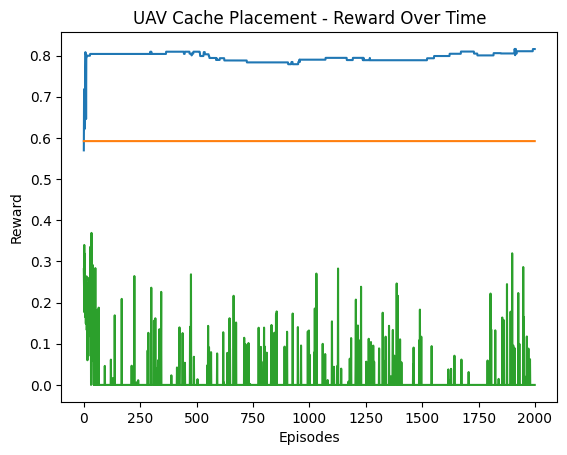

In [ ]:

# Plot Reward Curve
plt.plot(np.array(CHR))
plt.plot(np.array(CHR_Max))
plt.plot(np.array(SystemRegret))
# plt.plot(np.array(rewards) + np.array(SystemRegret))
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("UAV Cache Placement - Reward Over Time")
plt.show()


In [ ]:
import json
import numpy as np

rewards_list = rewards

# Save to JSON file
with open("2000iter_L5_random_X_rewards_lru.json", "w") as f:
    json.dump(rewards_list, f)


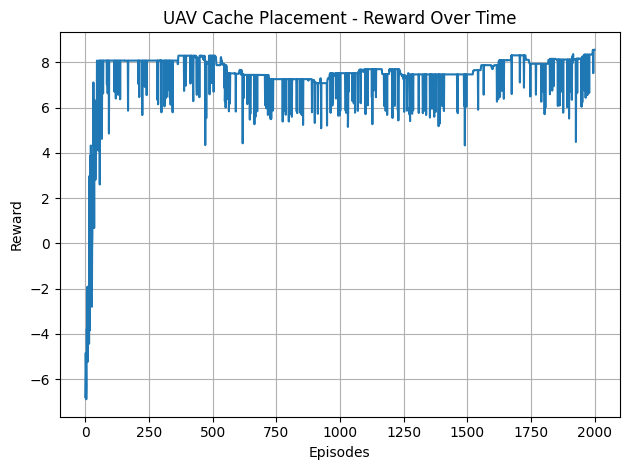

In [ ]:
# Load from JSON
with open("2000iter_L5_random_X_rewards_lru.json", "r") as f:
    loaded_rewards = json.load(f)

# Plot again
import matplotlib.pyplot as plt

plt.plot(np.array(loaded_rewards))
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("UAV Cache Placement - Reward Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import json
import numpy as np

rewards_list = rewards

# Save to JSON file
with open("2000iter_L5_Reward_rewards_lru.json", "w") as f:
    json.dump(rewards_list, f)
with open("2000iter_L5_CHR_rewards_lru.json", "w") as f:
    json.dump(CHR, f)
with open("2000iter_L5_CHRMAX_rewards_lru.json", "w") as f:
    json.dump(CHR_Max, f)
with open("2000iter_L5_Systemregret_rewards_lru.json", "w") as f:
    json.dump(SystemRegret, f)
with open("2000iter_L5_COST_rewards_lru.json", "w") as f:
    json.dump(Cost, f)


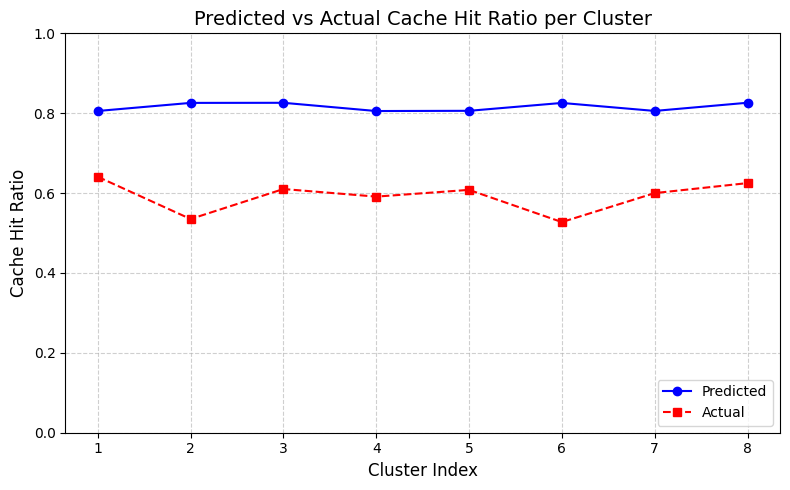

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json

predicted_hit_ratio = compute_cache_hit_ratio(state['Gamma_t'], state['predicted_Q_f'], UAVs_per_cluster)

actual_hit_ratio = compute_cache_hit_ratio(state['Xi_t'], actual_Q_f_all_uav, UAVs_per_cluster)

with open("2000iter_L5_cache_hit_found_lru_random_X.json", "w") as f:
    json.dump(predicted_hit_ratio.tolist(), f)

with open("2000iter_L5_actual_cache_hit_found_lru_random_X.json", "w") as f:
    json.dump(actual_hit_ratio.tolist(), f)

# X-axis: cluster index or UAV group
clusters = np.arange(1, len(predicted_hit_ratio) + 1)

# IEEE-style plot settings
plt.figure(figsize=(8, 5))
plt.plot(clusters, predicted_hit_ratio, marker='o', linestyle='-', color='blue', label='Predicted')
plt.plot(clusters, actual_hit_ratio, marker='s', linestyle='--', color='red', label='Actual')

# Styling for IEEE-like appearance
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Cluster Index', fontsize=12)
plt.ylabel('Cache Hit Ratio', fontsize=12)
plt.title('Predicted vs Actual Cache Hit Ratio per Cluster', fontsize=14)
plt.xticks(clusters)
plt.ylim(0, 1)
plt.legend(loc='lower right', fontsize=10)
plt.tight_layout()

# Save or show
plt.savefig("2000iter_L5_cache_hit_ratio_comparison_lru.pdf", format='pdf')  # for IEEE paper
plt.show()


In [ ]:
count = 0
for j in range(0,len(state['Gamma_t'])):
    temp = 0
    for i in state['Gamma_t'][j]:
        if i&1:
            temp+=1
    print(temp)
print("F' = ", F_prime)

33
33
33
33
33
33
33
33
F' =  33


RANDOM CACHING


In [ ]:
import numpy as np 
cache_matrix = np.zeros((U, F), dtype=int)
    
for u in range(U):
    cached_files = np.random.choice(F, size=F_prime, replace=False)
    cache_matrix[u, cached_files] = 1
print(cache_matrix)

count = 0
for j in range(0,len(cache_matrix)):
    temp = 0
    for i in cache_matrix[j]:
        if i&1:
            temp+=1
    print(temp)
print("F' = ", F_prime)


random_hit_ratio = compute_cache_hit_ratio(cache_matrix, actual_Q_f_all_uav, UAVs_per_cluster)
print(random_hit_ratio)

[[1 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 1 1
  1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 0
  0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0
  1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 1 1 0 1 1 1 1
  0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1
  0 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0]
 [0 1 1 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0
  0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1
  0 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1]
 [0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 1
  0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 1 0 1 0 0
  0 1 0 0 1 1 0 0 0 0 1 

In [ ]:
print(sum(random_hit_ratio)/U)

0.7963690481750647


In [ ]:

with open("2000iter_L5_random_cache_hit_found_lru_random_X.json", "w") as f:
    json.dump(random_hit_ratio.tolist(), f)
